In [1]:
import pandas as pd  # Importing pandas library for data manipulation and analysis
import numpy as np  # Importing numpy library for numerical computing
import re  # Importing re module for regular expressions
import matplotlib.pyplot as plt  # Importing matplotlib library for data visualization
import datetime  # Importing datetime module for date and time manipulation
from datetime import datetime  # Importing datetime class from datetime module
import random  # Importing random module for generating random numbers
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot  # Importing plotly for interactive plots
import plotly.express as px  # Importing plotly express for easy plotting
import plotly.graph_objects as go  # Importing plotly graph objects for advanced plotting
import plotly.figure_factory as ff  # Importing plotly figure factory for creating complex visualizations
from plotly.colors import n_colors  # Importing plotly colors for color management
import seaborn as sns  # Importing seaborn for statistical data visualization
from plotly.subplots import make_subplots  # Importing plotly subplots for creating multiple plots
from collections import Counter  # Importing Counter for counting hashable objects
init_notebook_mode(connected=True)  # Initializing plotly notebook mode for offline plotting
from wordcloud import WordCloud , ImageColorGenerator  # Importing wordcloud for creating word clouds
import nltk as nltk  # Importing nltk for natural language processing tasks
import string  # Importing string module for string manipulation
import re  # For regular expressions
import string  # For string operations
import contractions  # For expanding contractions
from nltk.corpus import stopwords  # For accessing stopwords list
from nltk.tokenize import word_tokenize  # Importing word_tokenize for tokenization
from nltk.corpus import stopwords  # Importing stopwords for removing common words
from sklearn.feature_extraction.text import TfidfVectorizer  # Importing TfidfVectorizer for text feature extraction
from textblob import TextBlob  # Importing TextBlob for sentiment analysis
from nltk.corpus import stopwords  # Importing stopwords again (duplicate import)
from textblob import TextBlob  # Importing TextBlob again (duplicate import)
import emoji  # Importing emoji for working with emojis
import contractions  # Importing contractions for expanding contractions in text
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer  # Importing stemmers and lemmatizer for word normalization
from collections import Counter  # Importing Counter again (duplicate import)
from sklearn.model_selection import train_test_split  # Importing train_test_split for splitting data into train and test sets
from xgboost import XGBClassifier  # Importing XGBoost classifier
from sklearn.metrics import accuracy_score, classification_report  # Importing accuracy_score and classification_report for model evaluation

In [2]:
# Libraries required for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, f1_score, auc
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay,confusion_matrix

In [3]:
# Function to save model as pickle file
import pickle

def save_model_pickle(trained_model, pickle_filename):
    """
    Save a trained model to a pickle file.

    Parameters:
        model: Trained machine learning model object.
        filename (str): Name of the pickle file to save the model to.
    """
    with open(pickle_filename, 'wb') as file:
        pickle.dump(trained_model, file)
    print(f"Model saved as {pickle_filename}")
    
# Function to load model from pickle file
def load_model_pickle(pickle_filename):
    """
    Load a trained model from a pickle file.

    Parameters:
        filename (str): Name of the pickle file containing the saved model.

    Returns:
        Trained machine learning model object.
    """
    with open(pickle_filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded from {pickle_filename}")
    return loaded_model


# Appliances

## Reading in the saved files and recreating the modeling dataset

In [4]:
# Complete filtered, cleaned and sampled data
appliances_filter_sample_clean_df = pd.read_csv('Appliances data and pickles/Appliances_Modeling_2.csv')
appliances_filter_sample_clean_df.shape

(49995, 35)

In [5]:
# Features data
appliances_features_x = pd.read_csv('Appliances data and pickles/Appliances_Modeling.csv')
appliances_features_x.shape

(49995, 1008)

In [6]:
# Defining the columns to be taken in modeling dataset
target_column = 'helpfulness_binary'  # Helpfulness is binary (1 or 0)

# Combining features and target variable into 1 modeling file
appliances_modeling_df = pd.concat([appliances_features_x, appliances_filter_sample_clean_df[target_column]], axis = 1)

## Data split into train, test and validation for modeling

In [7]:
# Separating features (X) and target variable (y)
X_app = appliances_features_x
y_app = appliances_modeling_df['helpfulness_binary']

# Step 1: Splitting the data into training (70%) and temporary data (30%)
X_train_app, X_temp_app, y_train_app, y_temp_app = train_test_split(X_app, y_app, test_size=0.3, random_state=123)

# Step 2: Splitting the temporary data into testing (50%) and validation (50%)
X_test_app, X_validation_app, y_test_app, y_validation_app = train_test_split(X_temp_app, y_temp_app, test_size=0.5, random_state=123)


In [8]:
# Deleting objects that are no longer needed for efficient memory utilization
del appliances_features_x
del X_temp_app
del y_temp_app

## Loading the saved modeling pickle files

In [9]:
# XGBoost - base and tuned models
xgb_base_classifier_appliances = load_model_pickle('Appliances data and pickles/xgb_base_classifier_appliances.pkl')
xgb_tuned_classifier_appliances = load_model_pickle('Appliances data and pickles/xgb_tuned_classifier_appliances.pkl')

Model loaded from Appliances data and pickles/xgb_base_classifier_appliances.pkl
Model loaded from Appliances data and pickles/xgb_tuned_classifier_appliances.pkl


[18:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



### Attempting model iteration with class weights 

As our data is imbalanced, we do not want our models to only focus on majority class 

Sample weights assign weights to each individual class 

This will help our models to focus on the minority class and hopefully address the imbalance

In [10]:
from sklearn.utils.class_weight import compute_sample_weight
# Calculating class weights for training data
sample_weights_train_app = compute_sample_weight(class_weight='balanced', y=X_train_app)
# Calculating class weights for validation data (required for hyperparameter tuning)
sample_weights_val_app = compute_sample_weight(class_weight='balanced', y=y_validation_app)

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
# Importing xgboost library
import xgboost as xgb
from xgboost import XGBClassifier

# Initializing XGBoost classifier
xgb_classifier_app_cw = xgb.XGBClassifier(random_state=123)

# Training the baseline model with class weights
xgb_classifier_app_cw.fit(X_train_app, y_train_app, sample_weight=sample_weights_train_app)

# Model predictions
xgb_predictions_app_cw = xgb_classifier_app_cw.predict(X_test_app)
xgb_accuracy_app_cw = accuracy_score(y_test_app, xgb_predictions_app_cw)

# Model performance
print("XGBoost base model for Appliances accuracy with class weights:", xgb_accuracy_app_cw)
print("XGBoost base model for Appliances with class weights classification report:")
print(classification_report(y_test_app, xgb_predictions_app_cw, zero_division='warn'))

XGBoost base model for Appliances accuracy with class weights: 0.9186558207761035
XGBoost base model for Appliances with class weights classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      6889
           1       0.00      0.00      0.00       610

    accuracy                           0.92      7499
   macro avg       0.46      0.50      0.48      7499
weighted avg       0.84      0.92      0.88      7499



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [12]:
# Saving as pickle file
save_model_pickle(xgb_classifier_app_cw, 'xgb_base_classifier_cw_appliances.pkl')

Model saved as xgb_base_classifier_cw_appliances.pkl


In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# XGBoost - Hyperparameter Tuning with class weights
xgb_param_grid_app = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Defining a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

xgb_grid_search_app_cw = GridSearchCV(xgb_classifier_app_cw, param_grid=xgb_param_grid_app, cv=3, scoring=roc_auc_scorer)

# Hyperparameter tuning on validation dataset with class weights
xgb_grid_search_app_cw.fit(X_validation_app, y_validation_app, sample_weight = sample_weights_val_app)

xgb_best_params_app_cw = xgb_grid_search_app_cw.best_params_
xgb_best_model_app_cw = xgb_grid_search_app_cw.best_estimator_

print("XGBoost Best Parameters for Appliances with class weights:", xgb_best_params_app_cw)
# Performance of tuned model with class weights
xgb_tuned_predictions_app_cw = xgb_best_model_app_cw.predict(X_test_app)
xgb_tuned_accuracy_app_cw = accuracy_score(y_test_app, xgb_tuned_predictions_app_cw)
print("XGBoost tuned model accuracy for Appliances with class weights:", xgb_tuned_accuracy_app_cw)
print("XGBoost tuned model for Appliances with class weights classification report:")
print(classification_report(y_test_app, xgb_tuned_predictions_app_cw, zero_division='warn'))

XGBoost Best Parameters for Appliances with class weights: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost tuned model accuracy for Appliances with class weights: 0.7415655420722763
XGBoost tuned model for Appliances with class weights classification report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      6889
           1       0.21      0.77      0.33       610

    accuracy                           0.74      7499
   macro avg       0.59      0.75      0.58      7499
weighted avg       0.91      0.74      0.80      7499



In [14]:
# Saving as pickle file
save_model_pickle(xgb_best_model_app_cw, 'xgb_tuned_classifier_cw_appliances.pkl')

Model saved as xgb_tuned_classifier_cw_appliances.pkl


In [15]:
# Deleting objects that are no longer needed for efficient memory utilization
del X_validation_app
del X_train_app

# Automotive

## Reading in the saved files and recreating the modeling dataset

In [16]:
# Complete filtered, cleaned and sampled data
automotive_filter_sample_clean_df = pd.read_csv('Automotive data and pickles/Automotive_Modeling_2.csv')
automotive_filter_sample_clean_df.shape

(50002, 35)

# Cellphone and accessories

## Reading in the saved files and recreating the modeling dataset

In [17]:
# Complete filtered, cleaned and sampled data
cell_filter_sample_clean_df = pd.read_csv('Cellphone data and pickles/cellphone_Modeling_2.csv')
cell_filter_sample_clean_df.shape

(50006, 35)

# Tools

## Reading in the saved files and recreating the modeling dataset

In [18]:
# Complete filtered, cleaned and sampled data
tools_filter_sample_clean_df = pd.read_csv('Tools data and pickles/Tools_Modeling_2.csv')
tools_filter_sample_clean_df.shape

(49990, 35)

## Combining all categories' datasets into 1 master dataframe

In [19]:
# Defining the list of metadata features + the target variable
meta_features = ['title_length', 'title_sentiment', 'emoji_non_ascii_count_title', 'review_sentiment',
                 'url_count_review', 'unique_word_count_review', 'review_age_days', 'image_available', 'helpfulness_binary']

# Function to preprocess and add category marker
def preprocess_and_add_category(df, category):
    df_meta = df[meta_features].copy()  # Selecting only meta features
    df_meta['category'] = category  # Adding category marker
    return df_meta

# Creating an empty DataFrame to store the consolidated data
consolidated_category_meta_df = pd.DataFrame()

# Appending each category DataFrame vertically to the consolidated DataFrame
for category, df in zip(['appliances', 'automotive', 'cellphones', 'tools'],
                        [appliances_filter_sample_clean_df, automotive_filter_sample_clean_df,
                         cell_filter_sample_clean_df, tools_filter_sample_clean_df]):
    df_meta = preprocess_and_add_category(df, category)
    consolidated_category_meta_df = pd.concat([consolidated_category_meta_df, df_meta], axis=0, ignore_index=True)

# Resetting the index of the consolidated DataFrame
consolidated_category_meta_df.reset_index(drop=True, inplace=True)

In [20]:
consolidated_category_meta_df.shape

(199993, 10)

In [21]:
# Converting 'category' column to one-hot encoding with prefix
one_hot_encoded_category = pd.get_dummies(consolidated_category_meta_df['category'], prefix='category')

# Dropping the original 'category' column along with the target to create the features dataset
consolidated_category_x = pd.concat([consolidated_category_meta_df.drop(['category', 'helpfulness_binary'], axis=1), 
                                     one_hot_encoded_category], axis=1)

## Data split into train, test and validation for modeling

In [22]:
# Separating features (X) and target variable (y)
X_comb = consolidated_category_x
y_comb = consolidated_category_meta_df['helpfulness_binary']

# Step 1: Splitting the data into training (70%) and temporary data (30%)
X_train_comb, X_temp_comb, y_train_comb, y_temp_comb = train_test_split(X_comb, y_comb, test_size=0.3, random_state=123)

# Step 2: Splitting the temporary data into testing (50%) and validation (50%)
X_test_comb, X_validation_comb, y_test_comb, y_validation_comb = train_test_split(X_temp_comb, y_temp_comb, 
                                                                                  test_size=0.5, random_state=123)


# Displaying the shapes of the resulting datasets
## Training ##
print("X_train shape for the combined dataset:", X_train_comb.shape)
print("y_train shape for the combined dataset:", y_train_comb.shape)
## Testing ##
print("X_test shape for the combined dataset:", X_test_comb.shape)
print("y_test shape for the combined dataset:", y_test_comb.shape)
## Validation ##
print("X_validation shape for the combined dataset:", X_validation_comb.shape)
print("y_validation shape for the combined dataset:", y_validation_comb.shape)


X_train shape for the combined dataset: (139995, 12)
y_train shape for the combined dataset: (139995,)
X_test shape for the combined dataset: (29999, 12)
y_test shape for the combined dataset: (29999,)
X_validation shape for the combined dataset: (29999, 12)
y_validation shape for the combined dataset: (29999,)


## XGBoost modeling for combined dataset - base and hyperparameter tuned

In [23]:
# XGBoost - base model for combined

# Initializing XGBoost classifier
xgb_classifier_comb = xgb.XGBClassifier(random_state=123)

# Training the baseline model
xgb_classifier_comb.fit(X_train_comb, y_train_comb)

# Model predictions
xgb_predictions_comb = xgb_classifier_comb.predict(X_test_comb)
xgb_accuracy_comb = accuracy_score(y_test_comb, xgb_predictions_comb)

# Model performance
print("XGBoost base model accuracy for combined dataset:", xgb_accuracy_comb)
print("XGBoost base model for combined dataset classification report:")
print(classification_report(y_test_comb, xgb_predictions_comb, zero_division='warn'))

XGBoost base model accuracy for combined dataset: 0.9059968665622188
XGBoost base model for combined dataset classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     27225
           1       0.42      0.04      0.08      2774

    accuracy                           0.91     29999
   macro avg       0.66      0.52      0.51     29999
weighted avg       0.86      0.91      0.87     29999



In [24]:
# Saving as pickle file
save_model_pickle(xgb_classifier_comb, 'xgb_base_classifier_combined.pkl')

Model saved as xgb_base_classifier_combined.pkl


In [25]:
# XGBoost - Hyperparameter Tuning
xgb_param_grid_comb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

xgb_grid_search_comb = GridSearchCV(xgb_classifier_comb, param_grid=xgb_param_grid_comb, cv=3, scoring='accuracy')

# Hyperparameter tuning on validation dataset
xgb_grid_search_comb.fit(X_validation_comb, y_validation_comb)
xgb_best_params_comb = xgb_grid_search_comb.best_params_
xgb_best_model_comb = xgb_grid_search_comb.best_estimator_

print("XGBoost Best Parameters:", xgb_best_params_comb)

xgb_tuned_predictions_comb = xgb_best_model_comb.predict(X_test_comb)

xgb_tuned_accuracy_comb = accuracy_score(y_test_comb, xgb_tuned_predictions_comb)
print("XGBoost tuned model for combined dataset accuracy:", xgb_tuned_accuracy_comb)
print("XGBoost tuned model for combined dataset classification report:")
print(classification_report(y_test_comb, xgb_tuned_predictions_comb, zero_division='warn'))

XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
XGBoost tuned model for combined dataset accuracy: 0.9074969165638854
XGBoost tuned model for combined dataset classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27225
           1       0.49      0.01      0.02      2774

    accuracy                           0.91     29999
   macro avg       0.70      0.50      0.48     29999
weighted avg       0.87      0.91      0.87     29999



In [26]:
# Saving as pickle file
save_model_pickle(xgb_best_model_comb, 'xgb_tuned_classifier_combined.pkl')

Model saved as xgb_tuned_classifier_combined.pkl


## XGBoost modeling for combined dataset - base and hyperparameter tuned with class weights

In [27]:
from sklearn.utils.class_weight import compute_sample_weight
# Calculating class weights for training data
sample_weights_train_comb = compute_sample_weight(class_weight='balanced', y=X_train_comb)
# Calculating class weights for validation data (required for hyperparameter tuning)
sample_weights_val_comb = compute_sample_weight(class_weight='balanced', y=y_validation_comb)

In [28]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
# Importing xgboost library
import xgboost as xgb
from xgboost import XGBClassifier

# Initializing XGBoost classifier
xgb_classifier_comb_cw = xgb.XGBClassifier(random_state=123)

# Training the baseline model with class weights
xgb_classifier_comb_cw.fit(X_train_comb, y_train_comb, sample_weight=sample_weights_train_comb)

# Model predictions
xgb_predictions_comb_cw = xgb_classifier_comb_cw.predict(X_test_comb)
xgb_accuracy_comb_cw = accuracy_score(y_test_comb, xgb_predictions_comb_cw)

# Model performance
print("XGBoost base model for combined dataset accuracy with class weights:", xgb_accuracy_comb_cw)
print("XGBoost base model for combined dataset with class weights classification report:")
print(classification_report(y_test_comb, xgb_predictions_comb_cw, zero_division='warn'))

XGBoost base model for combined dataset accuracy with class weights: 0.8067268908963632
XGBoost base model for combined dataset with class weights classification report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     27225
           1       0.17      0.27      0.21      2774

    accuracy                           0.81     29999
   macro avg       0.54      0.57      0.55     29999
weighted avg       0.85      0.81      0.83     29999



In [29]:
# Saving as pickle file
save_model_pickle(xgb_classifier_comb_cw, 'xgb_base_classifier_cw_combined.pkl')

Model saved as xgb_base_classifier_cw_combined.pkl


In [42]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# XGBoost - Hyperparameter Tuning with class weights
xgb_param_grid_comb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Defining a custom scoring function for ROC AUC
def roc_auc_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred)

xgb_grid_search_comb_cw = GridSearchCV(xgb_classifier_comb_cw, param_grid=xgb_param_grid_comb, cv=3, scoring=roc_auc_scorer)

# Hyperparameter tuning on validation dataset with class weights
xgb_grid_search_comb_cw.fit(X_validation_comb, y_validation_comb, sample_weight = sample_weights_val_comb)

xgb_best_params_comb_cw = xgb_grid_search_comb_cw.best_params_
xgb_best_model_comb_cw = xgb_grid_search_comb_cw.best_estimator_

print("XGBoost Best Parameters for combined dataset with class weights:", xgb_best_params_comb_cw)
# Performance of tuned model with class weights
xgb_tuned_predictions_comb_cw = xgb_best_model_comb_cw.predict(X_test_comb)
xgb_tuned_accuracy_comb_cw = accuracy_score(y_test_comb, xgb_tuned_predictions_comb_cw)
print("XGBoost tuned model accuracy for combined dataset with class weights:", xgb_tuned_accuracy_comb_cw)
print("XGBoost tuned model for combined dataset with class weights classification report:")
print(classification_report(y_test_comb, xgb_tuned_predictions_comb_cw, zero_division='warn'))

XGBoost Best Parameters for combined dataset with class weights: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost tuned model accuracy for combined dataset with class weights: 0.7117570585686189
XGBoost tuned model for combined dataset with class weights classification report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     27225
           1       0.21      0.79      0.34      2774

    accuracy                           0.71     29999
   macro avg       0.59      0.75      0.58     29999
weighted avg       0.90      0.71      0.77     29999



In [31]:
# Saving as pickle file
save_model_pickle(xgb_best_model_comb_cw, 'xgb_tuned_classifier_cw_combined.pkl')

Model saved as xgb_tuned_classifier_cw_combined.pkl


## Loading the recently created pickle files

In [33]:
# XGBoost - base and tuned models for Appliances with class weights
xgb_base_classifier_cw_appliances = load_model_pickle('xgb_base_classifier_cw_appliances.pkl')
xgb_tuned_classifier_cw_appliances = load_model_pickle('xgb_tuned_classifier_cw_appliances.pkl')

# XGBoost - base and tuned models for combined categories
xgb_base_classifier_combined = load_model_pickle('xgb_base_classifier_combined.pkl')
xgb_tuned_classifier_combined = load_model_pickle('xgb_tuned_classifier_combined.pkl')

# XGBoost - base and tuned models for combined categories with class weights
xgb_base_classifier_cw_combined = load_model_pickle('xgb_base_classifier_cw_combined.pkl')
xgb_tuned_classifier_cw_combined = load_model_pickle('xgb_tuned_classifier_cw_combined.pkl')

Model loaded from xgb_base_classifier_cw_appliances.pkl
Model loaded from xgb_tuned_classifier_cw_appliances.pkl
Model loaded from xgb_base_classifier_combined.pkl
Model loaded from xgb_tuned_classifier_combined.pkl
Model loaded from xgb_base_classifier_cw_combined.pkl
Model loaded from xgb_tuned_classifier_cw_combined.pkl


## Consolidation of modeling iteration results: Running the models on test data and getting evaluation metrics

In [34]:
# Consolidating all evaluation metrics results in 1 dataframe
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to generate evaluation results
def generate_evaluation_results_df(models, datasets):
    results = []
    
    for model_name, model in models.items():
        X_test, y_test = datasets[model_name]
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        # When denominator for precision is 0, 1 will be considered to fix zero division issue
        # Effectively means that precision will be 1 when there are no positive predictions
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc
        })
    
    return pd.DataFrame(results)

# Defining the base models to compare
base_models_xgb = {
    # First runs for base models
    "Appliances XGBoost base model": xgb_base_classifier_appliances,
    # Iterations with class weights for base models
    "Appliances XGBoost base model with class weights": xgb_base_classifier_cw_appliances,
    # Iterations with combined dataset for base models
    "Combined dataset XGBoost base model": xgb_base_classifier_combined,
    "Combined dataset XGBoost base model with class weights": xgb_base_classifier_cw_combined
}


# Defining the tuned models to compare
tuned_models_xgb = {
    # First runs for tuned models
    "Appliances XGBoost tuned model": xgb_tuned_classifier_appliances,
    # Iterations with class weights for tuned models
    "Appliances XGBoost tuned model with class weights": xgb_tuned_classifier_cw_appliances,
    # Iterations with combined dataset for tuned models
    "Combined dataset XGBoost tuned model": xgb_tuned_classifier_combined,
    "Combined dataset XGBoost tuned model with class weights": xgb_tuned_classifier_cw_combined    
}

# Providing the test datasets for all the models
datasets_xgb = {
    # Appliances
    "Appliances XGBoost base model": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model": (X_test_app, y_test_app),
    "Appliances XGBoost base model with class weights": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model with class weights": (X_test_app, y_test_app),
    # Combined
    "Combined dataset XGBoost base model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost base model with class weights": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model with class weights": (X_test_comb, y_test_comb)
}

# Generating evaluation results for base models
base_evaluation_results_df = generate_evaluation_results_df(base_models_xgb, datasets_xgb)

# Generating evaluation results for tuned models
tuned_evaluation_results_df = generate_evaluation_results_df(tuned_models_xgb, datasets_xgb)

# Combining the results of base and tuned models
consolidated_evaluation_results_df = pd.concat([base_evaluation_results_df, tuned_evaluation_results_df], ignore_index=True)

consolidated_evaluation_results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Appliances XGBoost base model,0.915855,0.403670,0.072131,0.122392,0.531348
1,Appliances XGBoost base model with class weights,0.918656,1.000000,0.000000,0.000000,0.500000
2,Combined dataset XGBoost base model,0.905997,0.417266,0.041817,0.076016,0.517933
3,Combined dataset XGBoost base model with class...,0.806727,0.167546,0.274694,0.208140,0.567815
4,Appliances XGBoost tuned model,0.917456,0.440000,0.054098,0.096350,0.524001
5,Appliances XGBoost tuned model with class weights,0.741566,0.206973,0.768852,0.326147,0.754001
6,Combined dataset XGBoost tuned model,0.907497,0.490566,0.009373,0.018394,0.504191
7,Combined dataset XGBoost tuned model with clas...,0.711757,0.214265,0.793800,0.337445,0.748599


In [35]:
# Function to evaluate multiple models using ROC curve with AUC being displayed on chart
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(ax, fpr, tpr, model_name):
    ax.plot(fpr, tpr, label=model_name)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()
    ax.grid(True)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    # Adding AUC value as text annotation
    ax.text(0.7, 0.2, f'AUC = {roc_auc:.2f}', bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

def evaluate_models_with_roc(models, datasets):
    num_models = len(models)
    ncols = 2  # 2 columns, can change as required
    nrows = -(-num_models // ncols)  # Ceiling division to calculate number of rows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))

    for idx, (model_name, model) in enumerate(models.items()):
        row = idx // ncols
        col = idx % ncols
        
        X_test, y_test = datasets[model_name]
        #y_pred = model.predict_proba(X_test)[:, 1]  # Can use predict_proba method in case of probabilities
        y_pred = model.predict(X_test)  # Directly using the predict method
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        
        if nrows > 1:
            plot_roc_curve(axes[row, col], fpr, tpr, model_name)
        else:
            plot_roc_curve(axes[col], fpr, tpr, model_name)

    plt.tight_layout()
    plt.show()

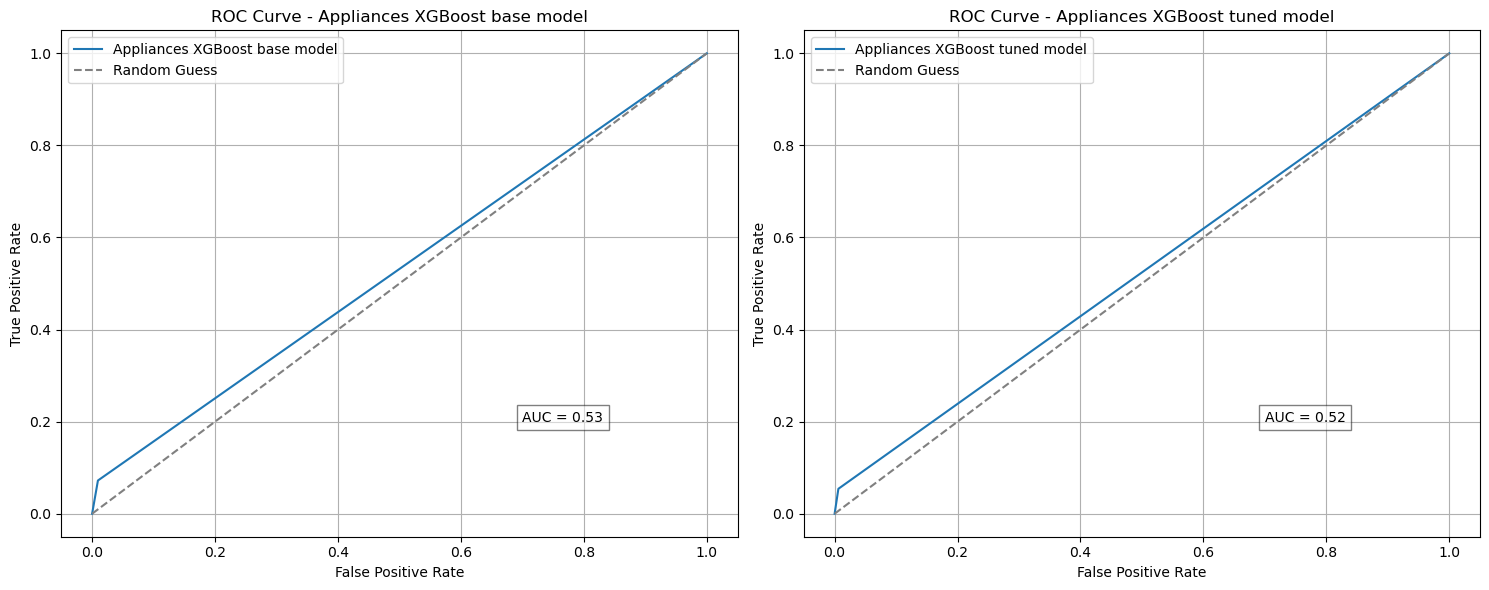

In [36]:
# Defining dictionaries for XGBoost for initial model runs
models_xgb = {
    "Appliances XGBoost base model": xgb_base_classifier_appliances,
    "Appliances XGBoost tuned model": xgb_tuned_classifier_appliances,    
}

datasets_xgb = {
    "Appliances XGBoost base model": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model": (X_test_app, y_test_app),
}

# Running the function to get pair plots across categories for XGBoost
evaluate_models_with_roc(models_xgb, datasets_xgb)

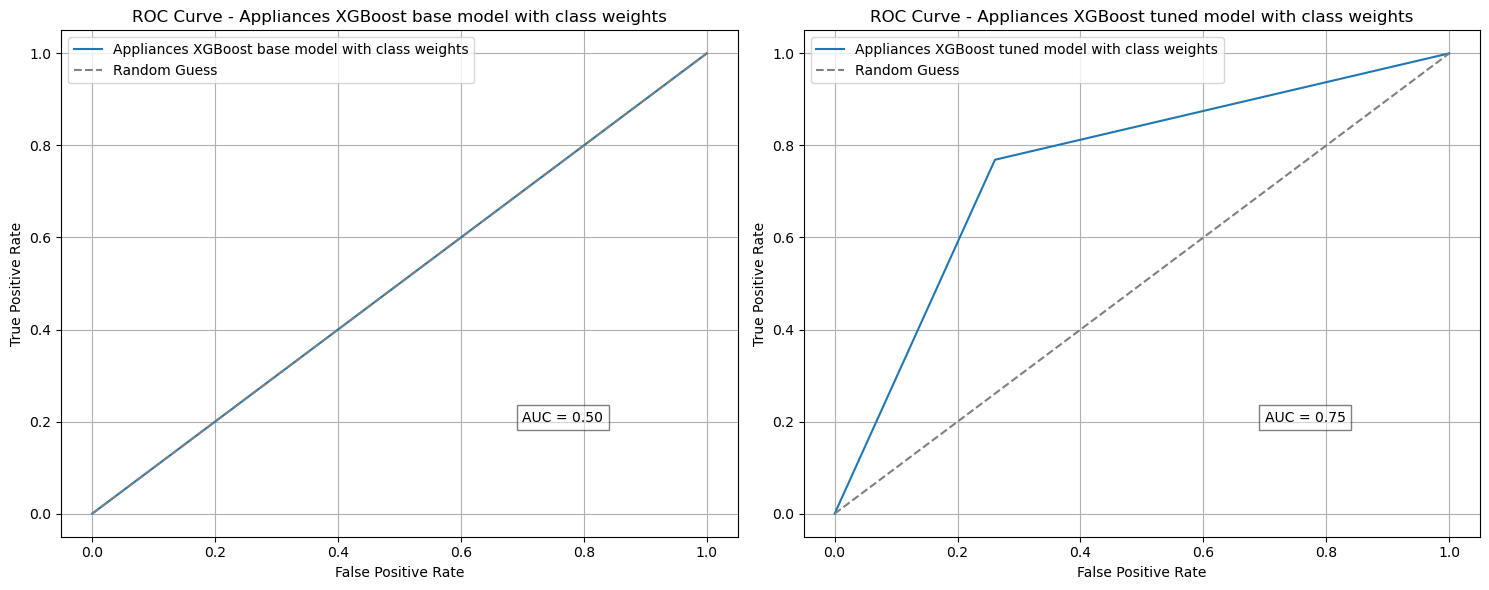

In [37]:
# Defining dictionaries for XGBoost class weight models
models_xgb_cw = {
    "Appliances XGBoost base model with class weights": xgb_base_classifier_cw_appliances,
    "Appliances XGBoost tuned model with class weights": xgb_tuned_classifier_cw_appliances,    
}

datasets_xgb_cw = {
    "Appliances XGBoost base model with class weights": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model with class weights": (X_test_app, y_test_app),
}

# Running the function to get pair plots across categories for XGBoost
evaluate_models_with_roc(models_xgb_cw, datasets_xgb_cw)

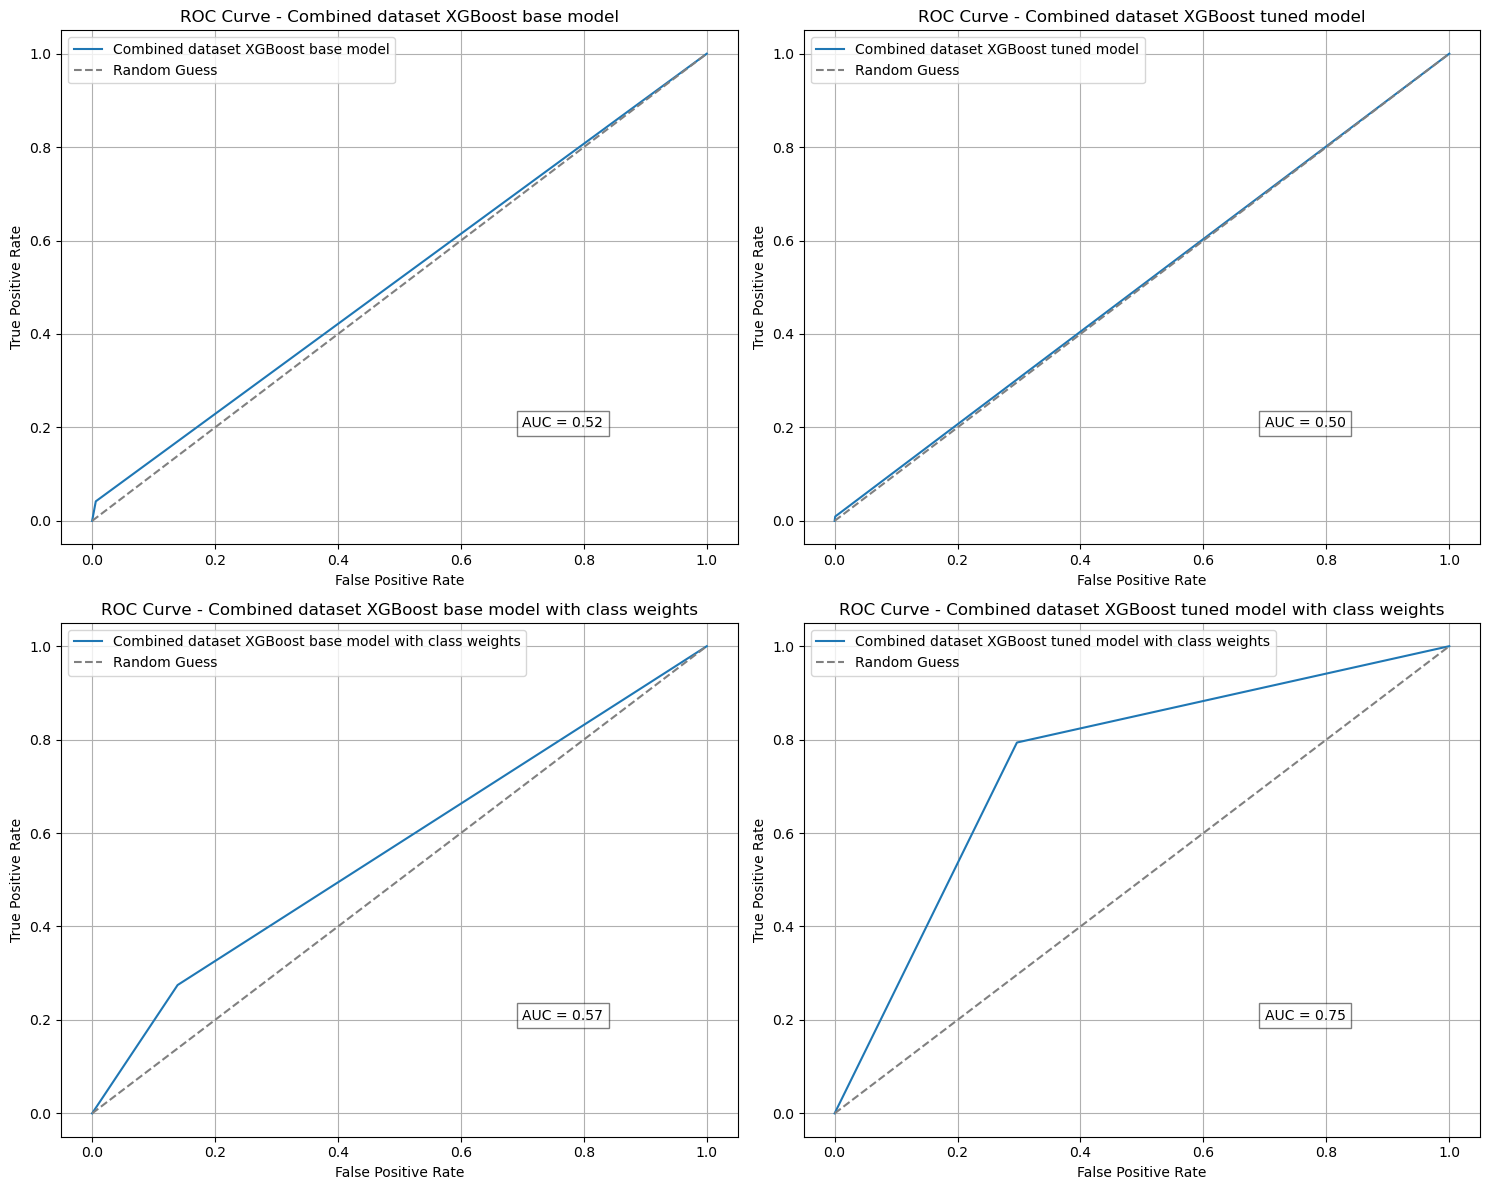

In [38]:
# Defining dictionaries for XGBoost for combined dataset
models_xgb_comb = {
    "Combined dataset XGBoost base model": xgb_base_classifier_combined,
    "Combined dataset XGBoost tuned model": xgb_tuned_classifier_combined,
    "Combined dataset XGBoost base model with class weights": xgb_base_classifier_cw_combined,
    "Combined dataset XGBoost tuned model with class weights": xgb_tuned_classifier_cw_combined,    
}

datasets_xgb_comb = {
    "Combined dataset XGBoost base model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost base model with class weights": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model with class weights": (X_test_comb, y_test_comb),
}

# Running the function to get pair plots across XGBoost iterations for combined dataset
evaluate_models_with_roc(models_xgb_comb, datasets_xgb_comb)

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to evaluate multiple models using confusion matrix
def plot_confusion_matrix(ax, cm, model_name):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix - {model_name}')

def evaluate_models_with_confusion_matrix(models, datasets):
    num_models = len(models)
    ncols = 2  # 2 columns, can change as required
    nrows = -(-num_models // ncols)  # Ceiling division to calculate number of rows
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))

    for idx, (model_name, model) in enumerate(models.items()):
        row = idx // ncols
        col = idx % ncols
        
        X_test, y_test = datasets[model_name]
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        if nrows > 1:
            plot_confusion_matrix(axes[row, col], cm, model_name)
        else:
            plot_confusion_matrix(axes[col], cm, model_name)

    plt.tight_layout()
    plt.show()


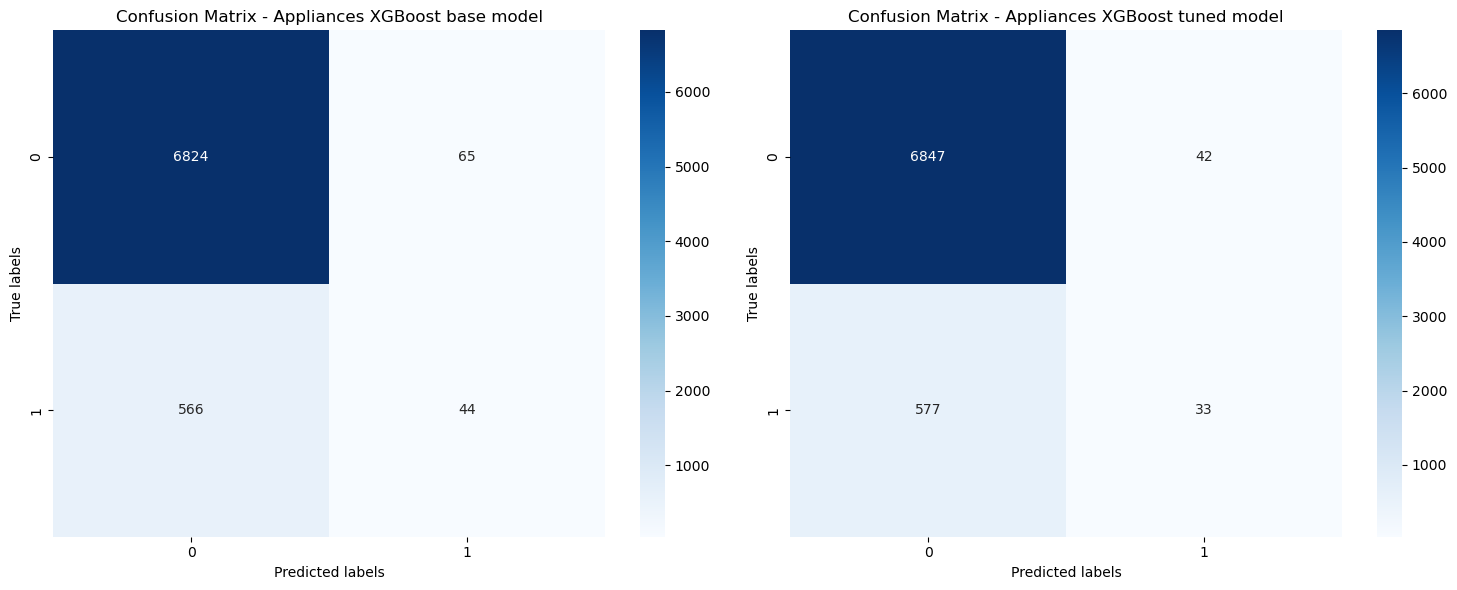

In [40]:
# Defining dictionaries for XGBoost for initial model runs
models_xgb = {
    "Appliances XGBoost base model": xgb_base_classifier_appliances,
    "Appliances XGBoost tuned model": xgb_tuned_classifier_appliances,    
}

datasets_xgb = {
    "Appliances XGBoost base model": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model": (X_test_app, y_test_app),
}

# Running the function to get pair plots across categories for XGBoost
evaluate_models_with_confusion_matrix(models_xgb, datasets_xgb)

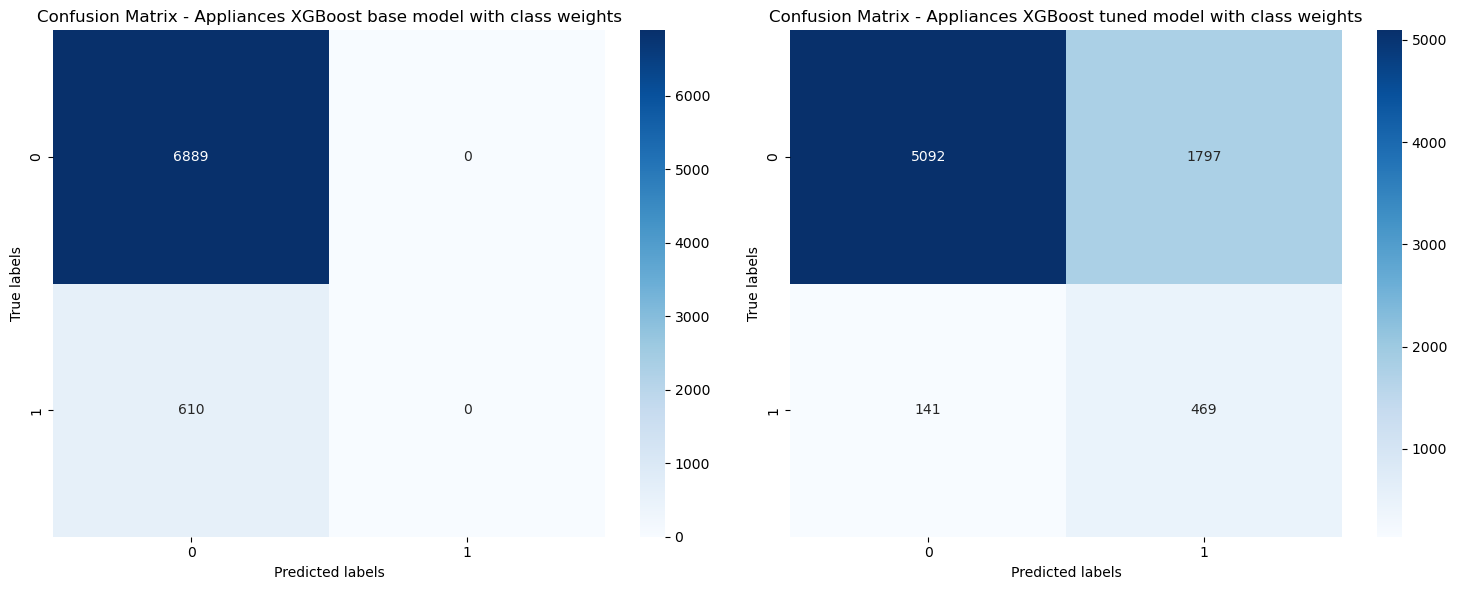

In [41]:
# Defining dictionaries for XGBoost class weight models
models_xgb_cw = {
    "Appliances XGBoost base model with class weights": xgb_base_classifier_cw_appliances,
    "Appliances XGBoost tuned model with class weights": xgb_tuned_classifier_cw_appliances,
    
}

datasets_xgb_cw = {
    "Appliances XGBoost base model with class weights": (X_test_app, y_test_app),
    "Appliances XGBoost tuned model with class weights": (X_test_app, y_test_app),
}

# Running the function to get pair plots across categories for XGBoost
evaluate_models_with_confusion_matrix(models_xgb_cw, datasets_xgb_cw)

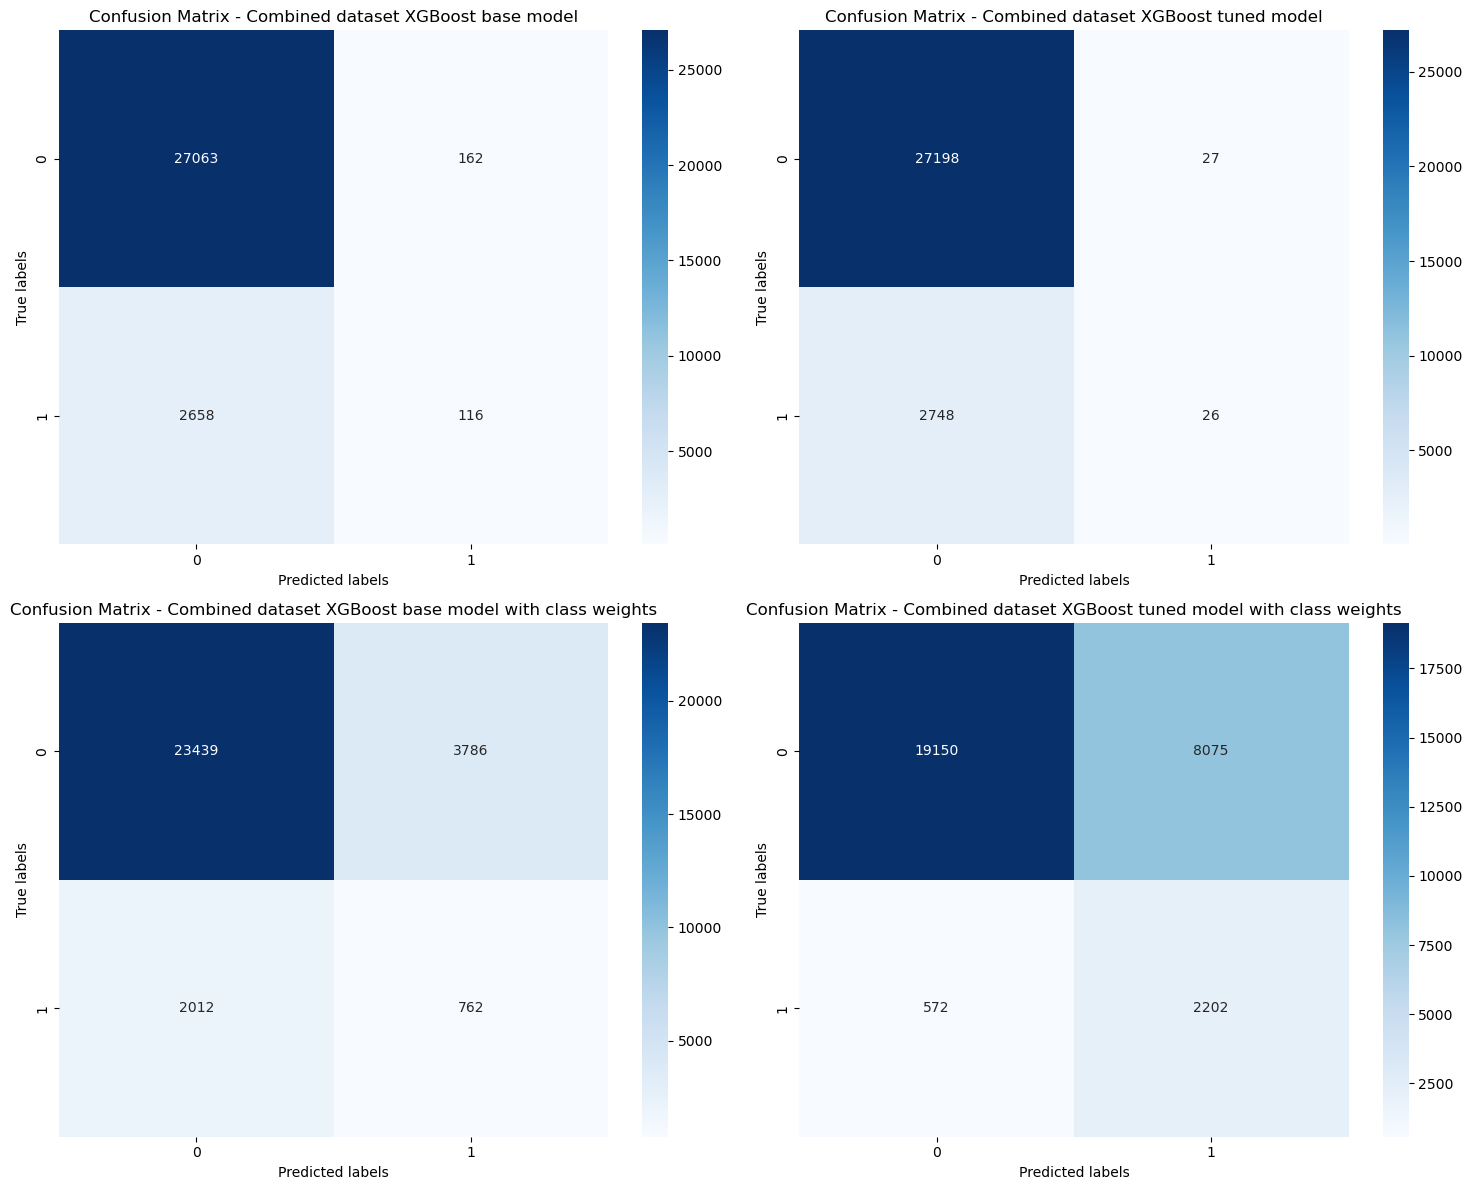

In [43]:
# Defining dictionaries for XGBoost for combined dataset
models_xgb_comb = {
    "Combined dataset XGBoost base model": xgb_base_classifier_combined,
    "Combined dataset XGBoost tuned model": xgb_tuned_classifier_combined,
    "Combined dataset XGBoost base model with class weights": xgb_base_classifier_cw_combined,
    "Combined dataset XGBoost tuned model with class weights": xgb_tuned_classifier_cw_combined,    
}

datasets_xgb_comb = {
    "Combined dataset XGBoost base model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost base model with class weights": (X_test_comb, y_test_comb),
    "Combined dataset XGBoost tuned model with class weights": (X_test_comb, y_test_comb),
}

# Running the function to get pair plots across XGBoost iterations for combined dataset
evaluate_models_with_confusion_matrix(models_xgb_comb, datasets_xgb_comb)